# Prototypical Network + task augmentation

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn.functional as F
from tqdm.auto import tqdm,trange
from pathlib import Path
import pandas as pd
import torch.nn.utils.prune as prune
import numpy as np
import random
import learn2learn as l2l
import pickle
import matplotlib.pyplot as plt

/home/samuel/.conda/envs/meta/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = "cuda" if torch.cuda.is_available() else "cpu"

In [128]:
train_ways = 5
train_sups = 5
train_querys = 5
val_ways = 5
val_sups =5
val_querys =5

In [129]:
with open("./data/test.pkl",'rb') as f:
    test_data = pickle.load(f)
with open("./data/train.pkl",'rb') as f:
    train_data = pickle.load(f)
with open("./data/validation.pkl",'rb') as f:
    val_data = pickle.load(f)

In [130]:
%%time
images = train_data["images"]
labels = train_data["labels"]
num_labels = np.unique(labels).shape[0]
num_new_labels = num_labels*3
n_data = int(len(labels)/num_labels)
for i in range(num_labels):
    images_of_one_class = images[i*n_data:(i+1)*n_data]
    new_img1 = np.array([np.rot90(img.copy(), axes=(2,1)) for img in images_of_one_class]) 
    new_img2 = np.array([np.rot90(img.copy(),2, axes=(2,1)) for img in images_of_one_class])
    train_data["images"] =np.append(train_data["images"],new_img1,axis=0)
    train_data["images"] =np.append(train_data["images"],new_img2,axis=0)
    train_data["labels"]=np.append(train_data["labels"],[num_labels+2*i]*n_data)
    train_data["labels"]=np.append(train_data["labels"],[num_labels+2*i+1]*n_data)

CPU times: user 49 s, sys: 56.5 s, total: 1min 45s
Wall time: 1min 45s


In [131]:
train_data["images"].shape

(115200, 3, 84, 84)

In [132]:
class Dataset(Dataset):
    def __init__(self,data,transform = None):
        self.transform = transform
        self.data=data
        self.images = np.transpose(self.data['images'],(0,2,3,1))
        self.labels = data['labels']
    def __len__(self): 
        return len(self.data['images'])
    def __getitem__(self,index):
        img = self.images[index]
        label = self.labels[index]
        if self.transform:
            img = self.transform(img)
        return img, label

In [133]:
train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(10),
        # transforms.RandomAffine(degrees = 0, translate=(0.1,0.1))
    ])
val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(10),
        # transforms.RandomAffine(degrees = 0, translate=(0.1,0.1))
])

In [134]:
train_dataset = Dataset(train_data,train_transform)
val_dataset = Dataset(val_data, val_transform)

In [135]:
train_dataset = l2l.data.MetaDataset(train_dataset)
val_dataset = l2l.data.MetaDataset(val_dataset)

In [136]:
task_transforms = [
    l2l.data.transforms.FusedNWaysKShots(train_dataset, n=train_ways, k=train_sups+train_querys),
    l2l.data.transforms.LoadData(train_dataset),
    l2l.data.transforms.RemapLabels(train_dataset),
    l2l.data.transforms.ConsecutiveLabels(train_dataset),
    # l2l.vision.transforms.RandomClassRotation(train_dataset,degrees = [0,10,15,20])
]
train_taskset =  l2l.data.TaskDataset(train_dataset, task_transforms)
task_transforms = [
    l2l.data.transforms.FusedNWaysKShots(val_dataset, n = val_ways, k=val_sups+val_querys),
    l2l.data.transforms.LoadData(val_dataset),
    l2l.data.transforms.RemapLabels(val_dataset),
    l2l.data.transforms.ConsecutiveLabels(val_dataset),
    # l2l.vision.transforms.RandomClassRotation(val_dataset,degrees = [0,10,15,20])
]
val_taskset =  l2l.data.TaskDataset(val_dataset, task_transforms, num_tasks=200)

In [137]:
import torch.nn as nn
import math

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, retain_activation=True, pool='max'):
        super(ConvBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        if retain_activation:
            self.block.add_module("ReLU", nn.ReLU(inplace=True))

        if pool == 'max':
            self.block.add_module("Pool2d", nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        elif pool == 'avg':
            self.block.add_module("Pool2d", nn.AvgPool2d(kernel_size=2, stride=2, padding=0))
        
    def forward(self, x):
        out = self.block(x)
        return out

# Embedding network used in Matching Networks (Vinyals et al., NIPS 2016), Meta-LSTM (Ravi & Larochelle, ICLR 2017),
# MAML (w/ h_dim=z_dim=32) (Finn et al., ICML 2017), Prototypical Networks (Snell et al. NIPS 2017).

class ProtoNetEmbedding(nn.Module):
    def __init__(self, x_dim=3, h_dim=64, z_dim=64, retain_last_activation=True, pool='max'):
        super(ProtoNetEmbedding, self).__init__()
        self.encoder = nn.Sequential(
          ConvBlock(x_dim, h_dim, pool=pool),
          ConvBlock(h_dim, h_dim, pool=pool),
          ConvBlock(h_dim, h_dim, pool=pool),
          ConvBlock(h_dim, z_dim, retain_activation=retain_last_activation, pool=pool),
        )
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.retain_last_activation = retain_last_activation
        self.pool = pool
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
               + 'x_dim=' + str(self.x_dim) + ', ' \
               + 'h_dim=' + str(self.h_dim) + ', ' \
               + 'z_dim=' + str(self.z_dim) + ', ' \
               + 'retain_last_activation=' + str(self.retain_last_activation) + ', ' \
               + 'pool=' + self.pool + ')'

In [148]:
from learn2learn.nn import PrototypicalClassifier
def pairwise_distances_logits(a, b):
    n = a.shape[0]
    m = b.shape[0]
    logits = -((a.unsqueeze(1).expand(n, m, -1) -
                b.unsqueeze(0).expand(n, m, -1))**2).sum(dim=2)
    return logits
def adaption(model, task, ways, shot, query_num, metric=None, device=None):
    if metric is None:
        metric = pairwise_distances_logits
    if device is None:
        device = model.device()
    data, labels = task
    data = data.to(device)
    labels = labels.to(device)
    classifier = PrototypicalClassifier(distance = "euclidean",normalize=True)
    
    sort = torch.sort(labels)
    data = data[sort.indices]
    labels = labels[sort.indices]
    
    # Compute support and query embeddings
    embeddings = model(data)
    support_indices = np.array(([True]*shot+[False]*query_num)*ways)
    query_indices = torch.from_numpy(~support_indices)
    support_indices = torch.from_numpy(support_indices)
    
    #method 1
    # support = embeddings[support_indices] #(25,1024)
    # support_labels = labels[support_indices].long()
    # query = embeddings[query_indices] #(25,1024)
    # query_labels = labels[query_indices].long()
    # classifier.fit_(support,support_labels)
    # logits = classifier(query)
    
    #method 2
    support = embeddings[support_indices] #(25,1024)
    query = embeddings[query_indices] #(25,1024)
    query_labels = labels[query_indices].long()
    proto = support.reshape(ways,shots,-1).mean(dim=1)
    logits = pairwise_distances_logits(query,proto)
    
    loss = F.cross_entropy(logits, query_labels)
    acc = torch.sum(torch.argmax(logits,dim=1)==query_labels)/len(labels)
    return loss, acc

In [149]:
def train(EPOCH,model,train_taskset, val_taskset,loss_function,opt, device,model_name, scheduler = None):
    res={
        "train_loss":[],
        "train_accuracy":[],
        "val_loss":[],
        "val_accuracy":[],  
    }
    log_file = f"./log/{model_name}.txt"
    for epoch in trange(1, EPOCH + 1):
        model.train()
        train_total_loss = 0
        train_total_acc = 0

        for i in range(fas):
            task = train_taskset.sample()
            train_loss, train_acc = adaption(model,
                                   task,
                                   train_ways,
                                   train_sups,
                                   train_querys,
                                   metric=pairwise_distances_logits,
                                   device=device)

            train_total_loss += train_loss.item()
            train_total_acc += train_acc.item()

            opt.zero_grad()
            train_loss.backward()
            opt.step()
        res['train_loss'].append(train_total_loss/fas)
        res['train_accuracy'].append(train_total_acc/fas)

        model.eval()

        val_total_loss = 0
        val_total_acc = 0
        with torch.inference_mode():
            for i, task in enumerate(val_taskset):
                val_loss, val_acc = adaption(model,
                                       task,
                                       val_ways,
                                       val_sups,
                                       val_querys,
                                       metric=pairwise_distances_logits,
                                       device=device)
                val_total_loss += val_loss.item()
                val_total_acc += val_acc.item()
        res['val_loss'].append(val_total_loss/len(val_taskset))
        res['val_accuracy'].append(val_total_acc/len(val_taskset))
        if scheduler:
            scheduler.step(val_total_loss/len(val_taskset))
        out = {
        "Epoch" : epoch,
        "train accuracy" : (train_total_acc/fas),
        "validation accuracy" : (val_total_acc/len(val_taskset)),
        "train loss" : (train_total_loss/fas),
        "validation loss" : (val_total_loss/len(val_taskset))
        }
        with open(log_file,"a") as f:
            f.write(str(out) + '\n')
        if epoch%50==0:
            MODEL_PATH = Path(f"./model/{model_name}")
            MODEL_PATH.mkdir(exist_ok=True,parents=True)
            torch.save(model.state_dict(),MODEL_PATH/f"model_{epoch}.pt")
            print(out)
    return res
                        

In [150]:
def test(model, test_data, loss_func, device):
    
    test_loss = 0
    test_acc = 0
    test_sup_images = test_data['sup_images']
    test_sup_labels = test_data['sup_labels']
    test_qry_images = test_data['qry_images']
    all_pred = []
    model.eval()
    with torch.inference_mode():
        for i in trange(len(test_sup_images)):
            test_sup_image = test_sup_images[i].to(device)
            query = test_qry_images[i].to(device)
            sup_embed = model(test_sup_image)
            proto = sup_embed.reshape(ways,shots,-1).mean(dim=1)
            logits = pairwise_distances_logits(query, proto)
            pred = torch.argmax(logits,dim=1).detach().cpu().numpy()
            all_pred += [item for sublist in pred for item in sublist]
    return all_pred

In [151]:
lr = 1e-3
EPOCHS = 500
fas = 100
model = l2l.vision.models.ResNet12Backbone().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss(reduction='mean')
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.5)
# scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=10, factor=0.5)
results  = train(EPOCHS, model, train_taskset, val_taskset, loss_func,opt, device, "protonet_ProtoNetEmbedding",scheduler = scheduler)

  0%|                                  | 0/500 [00:00<?, ?it/s]/home/samuel/.conda/envs/meta/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 10%|██▎                    | 50/500 [20:13<3:02:08, 24.29s/it]

{'Epoch': 50, 'train accuracy': 0.294199992120266, 'validation accuracy': 0.25529999304562806, 'train loss': 1.0371270921826363, 'validation loss': 1.333881276845932}


 20%|████▍                 | 100/500 [40:27<2:41:51, 24.28s/it]

{'Epoch': 100, 'train accuracy': 0.3293999907374382, 'validation accuracy': 0.28989999286830426, 'train loss': 0.8980241018533707, 'validation loss': 1.0980892853438855}


 30%|██████              | 150/500 [1:00:41<2:21:51, 24.32s/it]

{'Epoch': 150, 'train accuracy': 0.3453999915719032, 'validation accuracy': 0.29759999372065066, 'train loss': 0.810985982120037, 'validation loss': 1.0560856357216835}


 40%|████████            | 200/500 [1:20:55<2:01:20, 24.27s/it]

{'Epoch': 200, 'train accuracy': 0.37159998893737795, 'validation accuracy': 0.3266999915242195, 'train loss': 0.6921299666911364, 'validation loss': 0.9028659883141518}


 50%|██████████          | 250/500 [1:41:08<1:41:10, 24.28s/it]

{'Epoch': 250, 'train accuracy': 0.38059998989105226, 'validation accuracy': 0.32879999212920663, 'train loss': 0.6507824172079563, 'validation loss': 0.9683634334802628}


 60%|████████████        | 300/500 [2:01:22<1:20:52, 24.26s/it]

{'Epoch': 300, 'train accuracy': 0.3919999897480011, 'validation accuracy': 0.3271999907493591, 'train loss': 0.5760338498651981, 'validation loss': 1.0578773136436939}


 70%|██████████████      | 350/500 [2:21:35<1:00:45, 24.30s/it]

{'Epoch': 350, 'train accuracy': 0.395599989593029, 'validation accuracy': 0.343099992275238, 'train loss': 0.5634828222543001, 'validation loss': 0.8736975404620171}


 80%|█████████████████▌    | 400/500 [2:41:48<40:27, 24.28s/it]

{'Epoch': 400, 'train accuracy': 0.4011999887228012, 'validation accuracy': 0.34379999086260793, 'train loss': 0.5338518978655338, 'validation loss': 0.8690567252039909}


 90%|███████████████████▊  | 450/500 [3:02:01<20:12, 24.24s/it]

{'Epoch': 450, 'train accuracy': 0.41619998663663865, 'validation accuracy': 0.3567999901622534, 'train loss': 0.4575879243016243, 'validation loss': 0.7690677815675735}


100%|██████████████████████| 500/500 [3:22:15<00:00, 24.27s/it]

{'Epoch': 500, 'train accuracy': 0.4201999884843826, 'validation accuracy': 0.3535999897122383, 'train loss': 0.4562939759716392, 'validation loss': 0.758504229336977}


<Axes: >

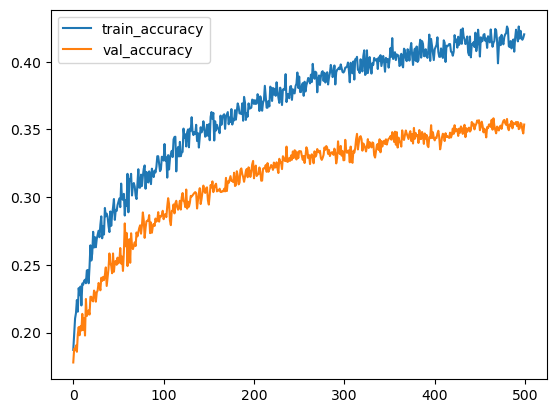

In [152]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
df1 = pd.DataFrame(results["train_accuracy"],columns=['train_accuracy'])
df2 = pd.DataFrame([i for i in results["val_accuracy"]],columns=['val_accuracy'])
df = pd.concat([df1,df2],axis=1)
df.plot()

<Axes: >

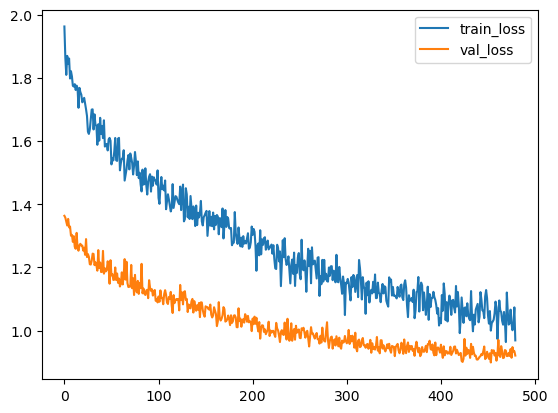

In [87]:
df1 = pd.DataFrame(results["train_loss"][20:],columns=['train_loss'])
df2 = pd.DataFrame([i for i in results["val_loss"]][20:],columns=['val_loss'])
df = pd.concat([df1,df2],axis=1)
df.plot()